In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [5]:
HOURS_PER_DAY = 20
DAYS_PER_WEEK = 7
DAYS_PER_YEAR = 365

# process the raw input data and generate input, output pair for the LSTM model
#
# input: [ [x[t - hours], ..., x[t - 1hour]], 
#          [x[t - days],  ..., x[t - 1day]], 
#          [x[t - weeks], ..., x[t - 1week]],
#          [x[t - years], ..., x[t - 1year]]  ]
# 
# output: x[t]
def create_dataset_years(data, hours=1, days=1, weeks=1, years=1):
    num_data = len(data) - HOURS_PER_DAY * DAYS_PER_YEAR * years
    x_arr, y_arr = np.zeros((num_data, 4, max(hours, days, weeks, years))), np.zeros((num_data,))
    
    for i in range(num_data):
        index = i
        
        for j in range(years):
            x_arr[i, 3, j] = data[index]
            index += HOURS_PER_DAY * DAYS_PER_YEAR
            
        index -= HOURS_PER_DAY * DAYS_PER_WEEK * weeks
        
        for j in range(weeks):
            x_arr[i, 2, j] = data[index]
            index += HOURS_PER_DAY * DAYS_PER_WEEK
            
        index -= HOURS_PER_DAY * days
        
        for j in range(days):
            x_arr[i, 1, j] = data[index]
            index += HOURS_PER_DAY
        
        x_arr[i, 0, 0:hours] = data[(index-hours):index]
        y_arr[i] = data[index]

    return x_arr, y_arr

# create an LSTM model to train with
def create_model():
    model = Sequential()  
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

# run the LSTM model with the given data
def run_model(data):
    hours = 3
    days = 4
    weeks = 5
    years = 5
    batch_size = 256
    
    # create model
    model = create_model()
    adam = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='mse')
    
    # prepare data
    x_data, y_data = create_dataset_years(data, hours, days, weeks, years)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
    
    # run model
    history = model.fit(x_train, y_train, epochs=200, batch_size=batch_size, validation_data=(x_val, y_val))
    score = model.evaluate(x_test, y_test, batch_size=batch_size)

    # predict future values
    predictions = np.concatenate(model.predict(x_test, batch_size))
    #plt.plot(predictions, (predictions - y_test), 'rx')
    
    # evaluate model
    SMAPE = np.mean(abs(predictions - y_test) / (abs(predictions) + abs(y_test)))
    RMSE = np.sqrt(np.mean((predictions - y_test)**2))
    
    return SMAPE, RMSE, history

In [6]:
# choose a station number and train the model with the data for the given station
station_number = 150
result = pd.read_csv('./data/result.csv', encoding='utf-8')
    
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.read_csv('./data/departure/%d_2008_to_2017.csv' % station_number,encoding='utf-8', dtype='float64')
data = np.concatenate(scaler.fit_transform(df.values.reshape(-1,1)))
    
SMAPE, RMSE, history = run_model(data)

Train on 22220 samples, validate on 5556 samples
Epoch 1/200
22220/22220 [==============================] - 7s 304us/step - loss: 0.0099 - val_loss: 0.0020
Epoch 2/200
22220/22220 [==============================] - 6s 286us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 3/200
22220/22220 [==============================] - 3s 149us/step - loss: 0.0025 - val_loss: 0.0015
Epoch 4/200
22220/22220 [==============================] - 3s 151us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/200
22220/22220 [==============================] - 3s 147us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/200
22220/22220 [==============================] - 3s 145us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 7/200
22220/22220 [==============================] - 4s 160us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/200
22220/22220 [==============================] - 4s 181us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/200
22220/22220 [==============================] - 5s 207us/step - loss: 0.0021 - val_l

22220/22220 [==============================] - 3s 154us/step - loss: 7.9233e-04 - val_loss: 4.9641e-04
Epoch 146/200
22220/22220 [==============================] - 4s 170us/step - loss: 7.8995e-04 - val_loss: 4.7693e-04
Epoch 147/200
22220/22220 [==============================] - 4s 186us/step - loss: 7.6825e-04 - val_loss: 4.9155e-04
Epoch 148/200
22220/22220 [==============================] - 4s 172us/step - loss: 7.7835e-04 - val_loss: 4.6282e-04
Epoch 149/200
22220/22220 [==============================] - 4s 169us/step - loss: 7.9973e-04 - val_loss: 4.8783e-04
Epoch 150/200
22220/22220 [==============================] - 4s 164us/step - loss: 7.9223e-04 - val_loss: 4.7120e-04
Epoch 151/200
22220/22220 [==============================] - 3s 154us/step - loss: 7.8235e-04 - val_loss: 4.6071e-04
Epoch 152/200
22220/22220 [==============================] - 3s 154us/step - loss: 7.6953e-04 - val_loss: 5.0642e-04
Epoch 153/200
22220/22220 [==============================] - 3s 152us/step - l

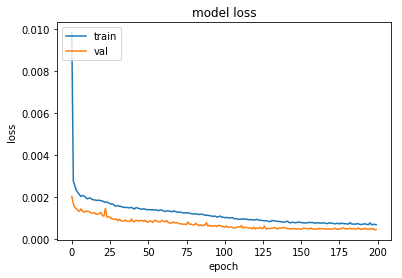

In [7]:
# plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
SMAPE

0.06067401554908337